## Finn's implementation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg, stats
from sklearn.metrics import pairwise

from plasma_data_handler import PlasmaDataHandler

In [6]:
t = PlasmaDataHandler('shot_166578.h5')

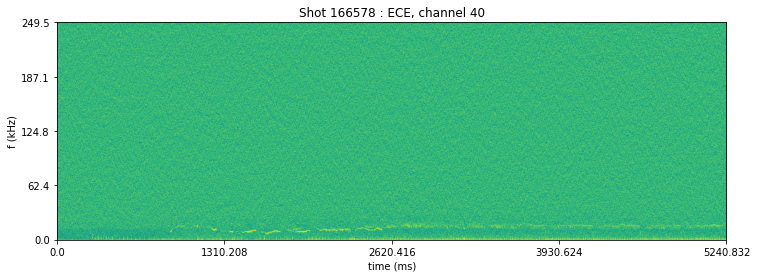

In [7]:
t.createSpectrogram('ECE', 40, 1024, True, scale=0.5)

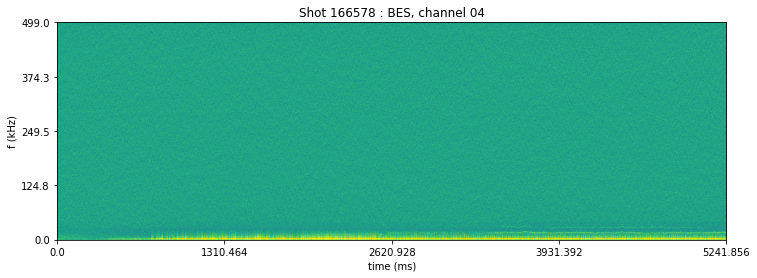

In [12]:
t.createSpectrogram('BES', 4, 1024, True, scale=0.5)

### SVD on the output

follows http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/

In [38]:
def omega(beta):
    """ follows http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/"""
    coef = [0.56, -0.95, 1.82, 1.43]
    poly = [beta ** (3 - n) for n in range(4)]
    return sum([c*p for c,p in zip(coef, poly)]);

def anomaly_score(test, train):
    """
    Returns an anomaly score for each member in test.  The score is computed as the fraction of 
    values in train that are less than the values of test, for each value of test.
    
    Parameters
    ----------
    test : ndarray
        The array of test points.
    train : ndarray
        The array of the train points
        
    Returns
    -------
    ndarray of scores
    """
    res = np.zeros_like(test, dtype=float)
    mag = len(train)
    for idx, val in enumerate(test):
        res[idx] = (val > train).sum() / mag
    return res

def computeSignal(u, s, vh, test, t_star):
    """
    Computes the signal part of the SVD.
    
    Parameters
    ----------
    u : ndarray
        Left singular matrix
    s : ndarray
        Singular values
    vh : ndarray
        Right singular matrix
    test : ndarray
        The array of test points.
    t_star : float
        The singular value threshold.
        
    Returns
    -------
    ndarray shaped like test
    """
    out = np.zeros_like(test, dtype=float)
    for idx, truth in enumerate(s > t_star):
        if truth:
            u1 = u[:, idx]
            v1 = vh[idx, :]
            s1 = s[idx]
            out += np.mean(v1) * s1 *  np.tile(u1, (test.shape[1],1)).T
    return out

def computeTestSignal(u, s, vh, test, t_star):
    """
    Computes the signal part of the SVD.
    
    Parameters
    ----------
    u : ndarray
        Left singular matrix
    s : ndarray
        Singular values
    vh : ndarray
        Right singular matrix
    test : ndarray
        The array of test points.
    t_star : float
        The singular value threshold.
        
    Returns
    -------
    ndarray shaped like test
    """
    out = np.zeros_like(test, dtype=float)
    n_singular = (s > t_star).sum()
    for idx in range(1, n_singular - 1):
        u1 = u[:, idx]
        v1 = vh[idx, :]
        s1 = s[idx]
        out += np.mean(v1) * s1 *  np.tile(u1, (test.shape[1],1)).T
    out += np.outer(np.dot(test.T, u[:, 0]), u[:, 0]).T
    return out

def computeTestAnomaly(u, s, vh, test, t_star):
    """
    Computes the *anomaly* part of the SVD accounting for the fact that v_0 always appears to be wrong.
    
    Parameters
    ----------
    u : ndarray
        Left singular matrix
    s : ndarray
        Singular values
    vh : ndarray
        Right singular matrix
    test : ndarray
        The array of test points.
    t_star : float
        The singular value threshold.
        
    Returns
    -------
    ndarray shaped like test
    """
    out = test.copy()
    n_singular = (s > t_star).sum()
    if n_singular > 1:  # subtract the "higher order" singular values
        for k in range(1, n_singular):
            u1 = u[:, k]
            v1 = vh[k, :]
            s1 = s[k]
            out -= np.mean(v1) * s1 *  np.tile(u1, (out.shape[1],1)).T
    # remove the zeroth singular value
    out -= np.outer(np.dot(out.T, u[:, 0]), u[:, 0]).T
    return out

def computeAnomaly(u, s, vh, test, t_star):
    """
    Computes the signal part of the SVD accounting for the fact that v_0 always appears to be wrong.
    
    Parameters
    ----------
    u : ndarray
        Left singular matrix
    s : ndarray
        Singular values
    vh : ndarray
        Right singular matrix
    test : ndarray
        The array of test points.
    t_star : float
        The singular value threshold.
        
    Returns
    -------
    ndarray shaped like test
    """
    n_singular = (s > t_star).sum()
    signal = np.matmul(u[:, :n_singular].T, test).sum(axis=0)
    return np.tile(signal, (test.shape[0], 1))

def computeTestVs(u, s, vh, test, t_star):
    """
    Computes the values of the Vs for the test dataset
    
    Parameters
    ----------
    u : ndarray
        Left singular matrix
    s : ndarray
        Singular values
    vh : ndarray
        Right singular matrix
    test : ndarray
        The array of test points.
    t_star : float
        The singular value threshold.
        
    Returns
    -------
    ndarray shaped like test, where the rows are the different sigma * Vs
    """
    return np.matmul(u.T, test)

shape of a: (512, 2901)
median singular value is 50.982


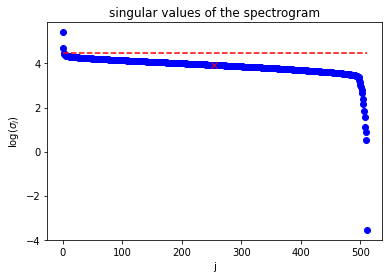

In [6]:
a = t.createSpectrogram('ECE', 10, 1024, False)

u, s, vh = np.linalg.svd(a, full_matrices = False)
med_sv = np.median(s)
med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]  # can probably use len(s) // 2
beta = a.shape[0] / a.shape[1]
t_star = omega(beta) * med_sv
print('shape of a: {:}'.format(a.shape))
print('median singular value is {:4.3f}'.format(med_sv))

plt.plot(range(len(s)),np.log(s),'ob')
plt.plot(med_idx, np.log(med_sv), 'xr')
plt.plot([0,len(s) - 1],[np.log(t_star)] * 2, '--r')
plt.xlabel('j')
plt.ylabel(r'log($\sigma_j$)')
plt.title('singular values of the spectrogram')
plt.show()

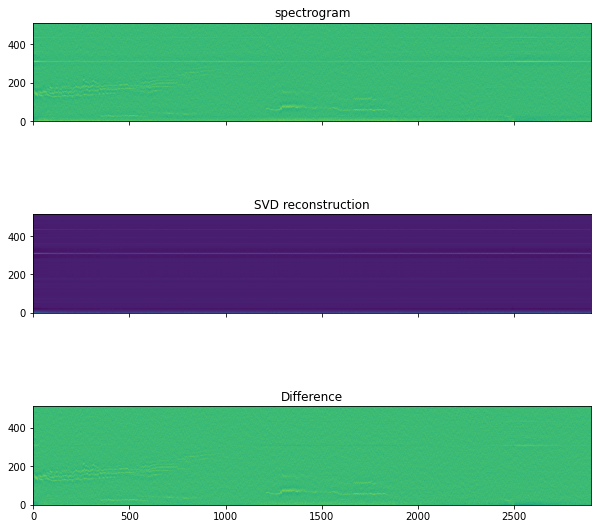

In [7]:
sv = s.copy()
sv[sv < t_star] = 0
av = computeTestSignal(u, s, vh, a, t_star)

fig, axs = plt.subplots(3, 1, squeeze=True, sharex=True, figsize=(10,10))
axs[0].imshow(a, origin='lower')
axs[0].set_title('spectrogram')
axs[1].imshow(av, origin='lower')
axs[1].set_title('SVD reconstruction')
axs[2].imshow(a - av, origin = 'lower')
axs[2].set_title('Difference')
plt.show()

## Train on early data, interpret later data

shape of a: (512, 2901)
median singular value is 22.606


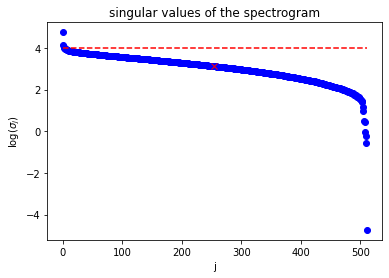

In [35]:
a = t.createSpectrogram('ECE', 10, 1024, False)
n_max = a.shape[1] // 4  # how many time steps to keep

train = a[:,:n_max].copy()
test = a[:,n_max:].copy()

u, s, vh = np.linalg.svd(train, full_matrices = False)
med_sv = np.median(s)
med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]  # can probably use len(s) // 2
beta = min(train.shape) / max(train.shape)
t_star = omega(beta) * med_sv
print('shape of a: {:}'.format(a.shape))
print('median singular value is {:4.3f}'.format(med_sv))

plt.plot(range(len(s)),np.log(s),'ob')
plt.plot(med_idx, np.log(med_sv), 'xr')
plt.plot([0,len(s) - 1],[np.log(t_star)] * 2, '--r')
plt.xlabel('j')
plt.ylabel(r'log($\sigma_j$)')
plt.title('singular values of the spectrogram')
plt.show()

There are 3 signal singular values


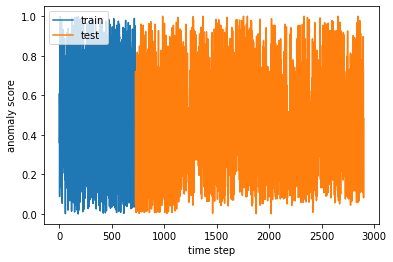

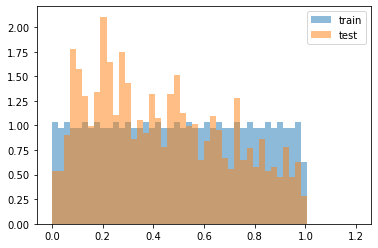

In [36]:
# compute the "signal" for the training data
sv = s.copy()
sv[sv < t_star] = 0
av = np.dot(np.dot(u, np.diag(sv)), vh)
print('There are {:d} signal singular values'.format((sv > t_star).sum()))
av = computeTestSignal(u, s, vh, train, t_star)

# compute the "signal" for the test data
# tv = computeSignal(u, s, vh, test, t_star)
tv = computeTestSignal(u, s, vh, test, t_star)

###### compute the anomaly score using a distribution ######
train_values = np.power(train - av, 2).sum(axis=0)  # training values
test_values = np.power(test - tv, 2).sum(axis=0)  # test values
train_as = anomaly_score(train_values, train_values)  # train anomaly scores
test_as = anomaly_score(test_values, train_values)  # test anomaly scores
# train_as = -1 * np.log(anomaly_score(train_values, train_values) + 1e-6)  # train anomaly scores
# test_as = -1 * np.log(anomaly_score(test_values, train_values) + 1e-6)  # test anomaly scores

###### compute the anomaly score using Chebyshev distance ######
# train_as = np.max(np.abs(train - av), axis=0)
# test_as = np.max(np.abs(test - tv), axis=0)

all_as = np.hstack((train_as, test_as))

plt.plot(range(len(train_as)), train_as, label='train')
plt.plot(range(len(train_as),len(train_as) + len(test_as)), test_as, label='test')
plt.legend(loc='upper left')
plt.xlabel('time step')
plt.ylabel('anomaly score')
plt.show()

max_value = np.max([np.max(train_as), np.max(test_as)])
tr, bins, _ = plt.hist(train_as, bins=50, range=(0, 1.2 * max_value), density=True, alpha=0.5, label="train")
te, bins, _ = plt.hist(test_as, bins=50, range=(0, 1.2 * max_value), density=True, alpha = 0.5, label="test")
plt.legend(loc='upper right')
plt.show()

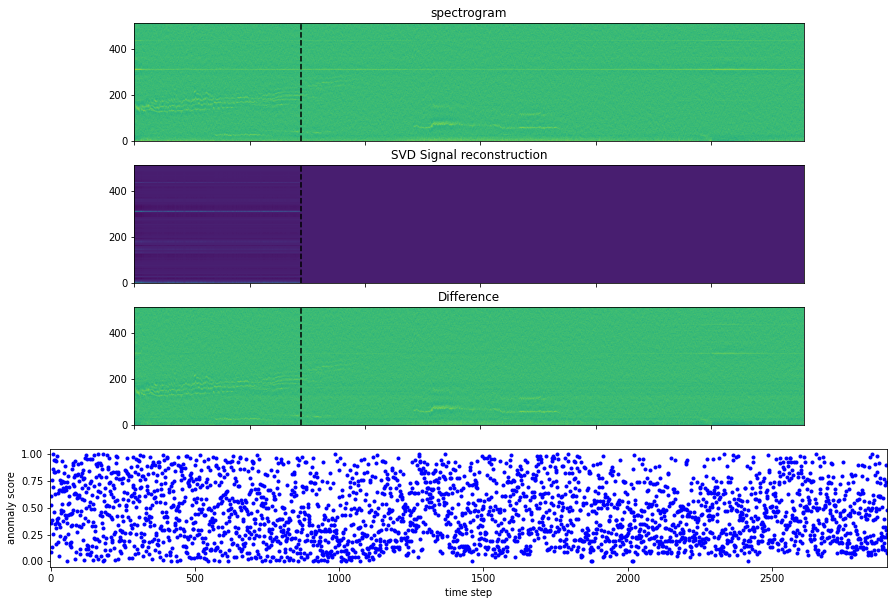

In [37]:
fig, axs = plt.subplots(4, 1, squeeze=True, sharex=True, figsize=(15,10))
axs[0].imshow(np.hstack((train, test)), origin='lower')
axs[0].set_title('spectrogram')
axs[1].imshow(np.hstack((av, np.zeros_like(test, dtype=float))), origin='lower')
axs[1].set_title('SVD Signal reconstruction')
axs[2].imshow(np.hstack((train - av, test - tv)), origin='lower')
axs[2].set_title('Difference')
axs[3].plot(range(a.shape[1]), all_as,'.b')
axs[3].set_xlabel('time step')
axs[3].set_ylabel('anomaly score')

for ax in axs[:-1]:
    ax.vlines([n_max-1], 0, train.shape[0]-1, colors=['k'], linestyles='dashed')

plt.show()

### Try to fit the Vs into the future

In [49]:
a = t.createSpectrogram('ECE', 10, 1024, False)
n_max = a.shape[1] // 4  # how many time steps to keep


##### SVD on the train/test split #####
train = a[:,:n_max].copy()
test = a[:,n_max:].copy()

u, s, vh = np.linalg.svd(train, full_matrices = False)
med_sv = np.median(s)
med_idx = np.argpartition(s, len(s) // 2)[len(s) // 2]  # can probably use len(s) // 2
beta = min(train.shape) / max(train.shape)
t_star = omega(beta) * med_sv
print('median singular value is {:4.3f}'.format(med_sv))

# compute the "signal" for the training data
sv = s.copy()
sv[sv < t_star] = 0
n_sing = (sv > t_star).sum()
# av = np.dot(np.dot(u, np.diag(sv)), vh)
av = computeSignal(u, s, vh, test, t_star)
print('There are {:d} signal singular values for train/test split'.format(n_sing))

##### SVD on the full data #####
U, S, VH = np.linalg.svd(a, full_matrices = False)
med_SV = np.median(S)
med_IDX = np.argpartition(S, len(S) // 2)[len(S) // 2]  # can probably use len(s) // 2
BETA = min(a.shape) / max(a.shape)
T_star = omega(BETA) * med_SV
print('median singular value is {:4.3f}'.format(med_SV))

# compute the "signal" for the training data
SV = S.copy()
SV[SV < t_star] = 0
n_SING = (SV > T_star).sum()
AV = np.dot(np.dot(U, np.diag(SV)), VH)
print('There are {:d} signal singular values for the full a matrix'.format(n_SING))

median singular value is 22.606
There are 3 signal singular values for train/test split
median singular value is 50.982
There are 3 signal singular values for the full a matrix


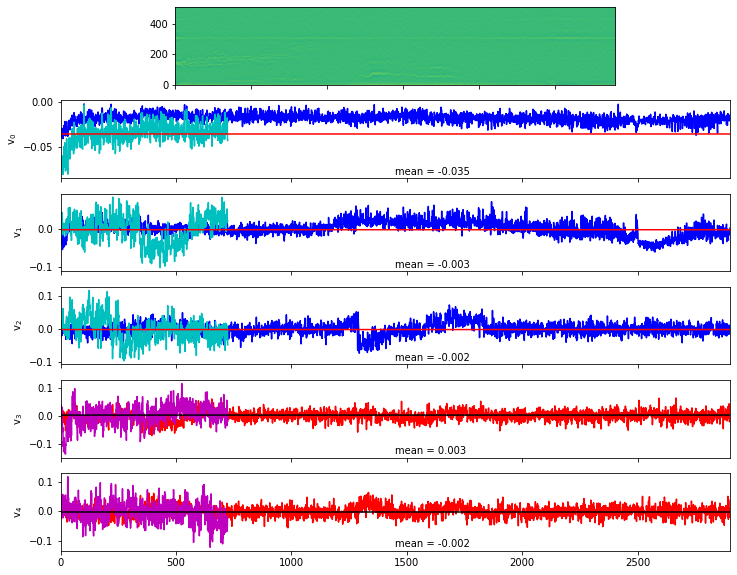

In [50]:
def makeFitLine(pn, x):
    """
    Makes a line for plotting the numpy.polyfit with range x.
    
    Parameters
    ----------
    pn : ndarray of float
        The coefficients of the polynomial fit.
    x : ndarray of float
        The x points to evaluate the fit at.
    """
    output = np.zeros_like(x, dtype=float)
    for idx, p in enumerate(pn):
        output += p * np.power(x, len(pn) - idx - 1)
    return output

n_extra = 2

fig, axs = plt.subplots(n_sing + 1 + n_extra, 1, sharex=True, figsize=(12,10))

axs[0].imshow(a, origin='lower')

for idx in range(n_sing + n_extra):
    V1 = VH[idx, :]
    X1 = list(range(len(V1)))
    v1 = vh[idx, :]
    x1 = list(range(len(v1)))
    
    mean_v = np.mean(v1)
    
    fit_nomials = np.polyfit(x1, v1, 0)
    
    if idx < n_sing:
        colors = ['b', 'c', 'r']
    else:
        colors = ['r', 'm', 'k']
    
    ax = axs[idx + 1]
    ax.plot(X1, V1, '-', color=colors[0])
    ax.plot(x1, v1, '-', color=colors[1])
    ax.plot(X1, makeFitLine(fit_nomials, X1), colors[2])
    ax.set_ylabel(r'v$_{:d}$'.format(idx))
    ax.text(X1[len(X1) // 2], np.min(v1), 'mean = {:4.3f}'.format(mean_v))

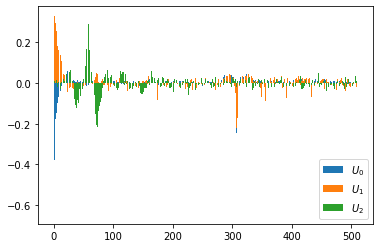

In [51]:
# this is incomplete u and U are defined up to a - sign, you must account for that

ux = range(u.shape[0])
for idx in range(n_sing):
#     plt.bar(ux, u[:, idx], label=r'$u_{:d}$'.format(idx))
    plt.bar(ux, U[:, idx], label=r'$U_{:d}$'.format(idx))

plt.legend(loc='lower right')
plt.show()

### Compare the v's from train/test to the v's from the full window

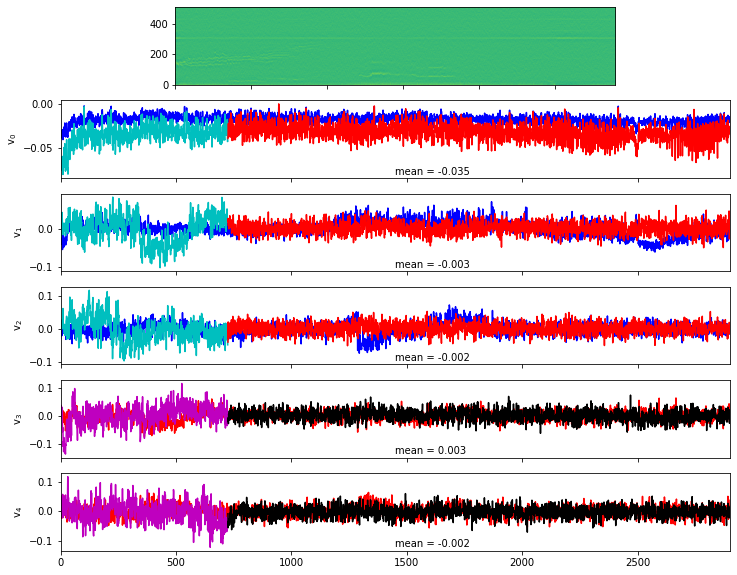

In [55]:
sVs = computeTestVs(u, s, vh, test, t_star)

n_extra = 2

fig, axs = plt.subplots(n_sing + 1 + n_extra, 1, sharex=True, figsize=(12,10))

axs[0].imshow(a, origin='lower')

for idx in range(n_sing + n_extra):
    # full matrix data
    V1 = VH[idx, :]
    X1 = list(range(len(V1)))
    # train region data
    v1 = vh[idx, :]
    x1 = list(range(len(v1)))
    # test region data
    vv1 = sVs[idx, :] / s[idx]
    xx1 = list(range(len(v1), len(v1) + len(vv1)))
    
    mean_v = np.mean(v1)
    
    fit_nomials = np.polyfit(x1, v1, 0)
    
    if idx < n_sing:
        colors = ['b', 'c', 'r']
    else:
        colors = ['r', 'm', 'k']
    
    ax = axs[idx + 1]
    ax.plot(X1, V1, '-', color=colors[0])
    ax.plot(x1, v1, '-', color=colors[1])
    ax.plot(xx1, vv1, '-', color=colors[2])
    ax.set_ylabel(r'v$_{:d}$'.format(idx))
    ax.text(X1[len(X1) // 2], np.min(v1), 'mean = {:4.3f}'.format(mean_v))

### Solve the problem with the offset in v_0

There is a rather obvious problem in the above cells: the v_0 term in the train/test split is always larger (absolute value sense), than in the full matrix.  Account for this by treating the u_0/v_0 term separately.

I did this in computeTestSignal above.

### Do cheap anomaly detection

follows: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html

In [82]:
import time

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

Training One-Class SVM ...
Time to train: 3.572 seconds
Training Isolation Forest ...
Time to train: 1.427 seconds
Training Local Outlier Factor ...
Time to train: 0.417 seconds


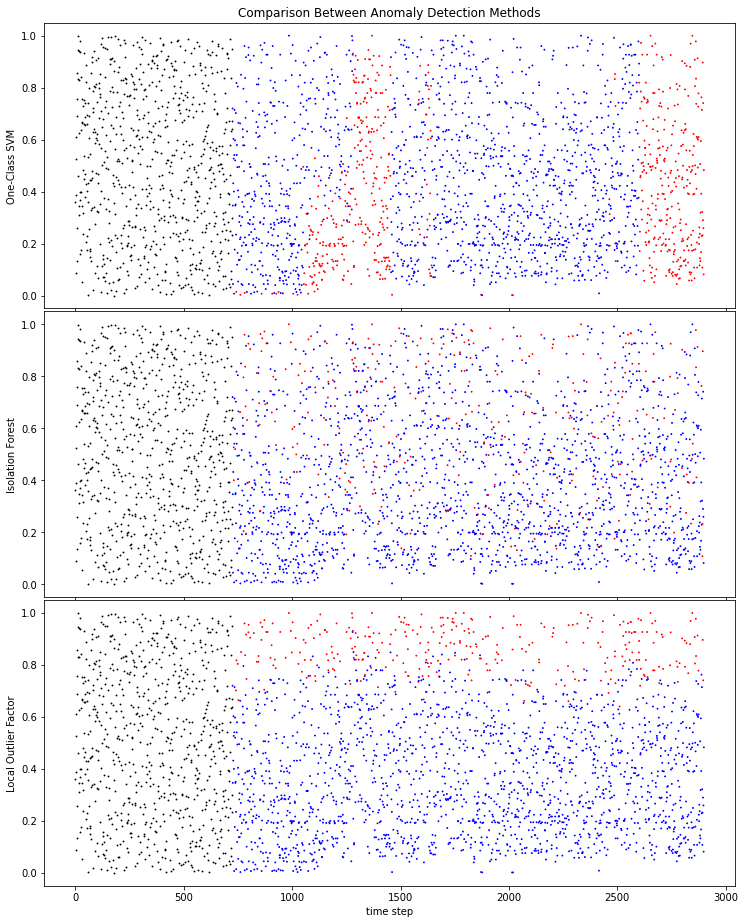

In [83]:
# Example settings
n_samples = test.shape[1]
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
#     ("Robust Covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

scaler = StandardScaler()
scaler.fit(train.T)
x = scaler.transform(test.T)

fig, axs = plt.subplots(len(anomaly_algorithms), 1, sharex=True, 
                        figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

colors = ['red', 'blue']
plt_num = 0

for name, algorithm in anomaly_algorithms:
    ax = axs[plt_num]
    print('Training {:s} ...'.format(name))
    t0 = time.time()
    # fit the data and tag outliers
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(x)
    else:
        y_pred = algorithm.fit(x).predict(x)
    t1 = time.time()
    print('Time to train: {:4.3f} seconds'.format(t1-t0))
    cs = [colors[0] if j <= 0 else colors[1] for j in y_pred]
    
    n_train = len(train_as)
    ax.scatter(range(n_train),train_as, s=3, c='black', marker='.')
    ax.scatter(range(n_train, len(y_pred) + n_train), test_as, s=3, c=cs, marker='.')

    ax.set_ylabel(name)

    if plt_num == 0:
        ax.set_title('Comparison Between Anomaly Detection Methods')
    elif plt_num == len(anomaly_algorithms) - 1:
        ax.set_xlabel('time step')

    plt_num += 1

plt.show()

## Ryan's implementation

In [13]:
path = '/gpfs/slac/staas/fs1/g/coffee_group/edgeml_fes_data/ecebes'
shot = 180625

def getextrema(t1, t2):
    tmin = np.max([np.min(t1), np.min(t2)])
    tmax = np.min([np.max(t1), np.max(t2)])
    return tmin, tmax


def getmask(shp):
    mask = [np.zeros(shp, dtype=float) for k in range(4)]
    MASK = [np.zeros(shp, dtype=complex) for k in range(4)]
    mask[0][:3, 1] = 1.
    mask[1][1, :3] = 1.
    mask[2][:3, :3] = np.eye(3)
    mask[3][:3, :3] = np.fliplr(np.eye(3))
    for i in range(len(mask)):
        mask[i] = np.roll(np.roll(mask[i], -1, axis=0), -1, axis=1)
        MASK[i] = np.fft.fft2(mask[i])
    return mask, MASK


def buildfilt(nsamples, nrolls, cutoff=0.01):
    FREQ = np.fft.fftfreq(nsamples)
    filt = np.zeros(FREQ.shape[0], dtype=float)
    inds = np.where(np.abs(FREQ) < cutoff)
    filt[inds] = 0.5 * (1. + np.cos(np.pi * FREQ[inds] / cutoff))
    return np.tile(filt, (nrolls, 1)).T


def CoffeeProcess(path, shot, instrument, channel, nsamples):
    ecefile = '%s/%i%s' % (path, shot, 'ECE')
    besfile = '%s/%i%s' % (path, shot, 'BES')

    data_ece = np.load(ecefile, allow_pickle=True)
    data_bes = np.load(besfile, allow_pickle=True)

    chans_ece = list(data_ece.keys())
    chans_bes = list(data_bes.keys())

    t_ece = ((data_ece[chans_ece[0]]['data.time'] + 0.00025) * 1e3).astype(int)
    t_bes = ((data_bes[chans_bes[0]]['data.time'] + 0.00025) * 1e3).astype(int)

    tmin, tmax = getextrema(t_bes, t_ece)
    print(tmin, tmax)

    inds_ece_coince = np.where((t_ece >= tmin) * (t_ece <= tmax))
    inds_bes_coince = np.where((t_bes >= tmin) * (t_bes <= tmax))
    sz_ece = t_ece[inds_ece_coince].shape[0]
    sz_bes = t_bes[inds_bes_coince].shape[0]

    print('sz_ece = %i\tsz_bes = %i\tsz_bes-2*sz_ece = %i' % (
    sz_ece, sz_bes, (sz_bes - 2 * sz_ece)))
    nfolds = int(sz_ece // nsamples)
    print('nfolds*nsamples = ', nfolds * nsamples)
    # use the times directly
    t = t_ece[inds_ece_coince[0][:nsamples * nfolds]].reshape(nfolds,
                                                              nsamples).T

    # set up the histogram and fit
    hbins = [i for i in range(256 + 1)]
    fitlim = int(8)
    hfit = np.array(hbins[1:fitlim])
    hfitmat = np.c_[
        [int(1) for i in range(fitlim - 1)], hfit, hfit ** 2, hfit ** 3]
    mask, MASK = getmask((nsamples, nfolds))

    if instrument.lower() == 'ece': # ECE
        ch = 'ecevs{:0>2d}'.format(channel)
        x = data_ece[ch]['data.ECE'][
            inds_ece_coince[0][:nsamples * nfolds]].reshape(nfolds, nsamples).T
    else: # BES
        ch = 'besfu{:0>2d}'.format(channel)
        x = data_bes[ch]['data.BES'][
            inds_bes_coince[0][:nsamples * nfolds]].reshape(nfolds, nsamples).T
    X = np.fft.fft(x, axis=0)
    AX = np.abs(X)
    if np.max(AX) == 0:
        return
    #OUT = np.log(np.power(AX, int(2)))
    OUT = np.log(AX + 1e-12)
#     BG = np.fft.ifft(
#         np.fft.fft(OUT.copy(), axis=0) * buildfilt(nsamples, nfolds,
#                                                    cutoff=0.05), axis=0).real
    filt = np.ones((50, nfolds)) / 50
    BG = signal.fftconvolve(OUT, filt, mode='same', axes=0)
    
    OUT = OUT - BG
    OUT[0, :] = 0
    OUT -= np.mean(OUT)
    OUT *= fitlim / np.std(OUT)  # *(OUT>hbins[0])

    data = OUT[:nsamples // 2, :] #.astype(np.int16)

    # create the filtered data
    QOUT = np.fft.fft2(OUT)
    NEWOUT = [np.zeros(QOUT.shape, dtype=float) for i in range(len(MASK))]
    for i in range(len(MASK)):
        NEWOUT[i] = np.fft.ifft2(QOUT * MASK[i]).real
    for i in range(len(MASK)):
        NEWOUT[0] = np.where(NEWOUT[i] > NEWOUT[0], NEWOUT[i], NEWOUT[0])
    data_filt = NEWOUT[0][:nsamples // 2, :].astype(np.int16)

    return t, data, data_filt

In [14]:
t, d, df = CoffeeProcess(path, shot, 'ECE', 20, 1024)

200000 6143150
sz_ece = 2971576	sz_bes = 5943151	sz_bes-2*sz_ece = -1
nfolds*nsamples =  2970624


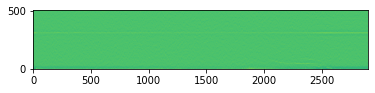

In [15]:
plt.imshow(d, origin='lower')

## Manually work through the two implimentations to find differences

In [16]:
nsamples = 1024

ecefile = '%s/%i%s' % (path, shot, 'ECE')
besfile = '%s/%i%s' % (path, shot, 'BES')

data_ece = np.load(ecefile, allow_pickle=True)
data_bes = np.load(besfile, allow_pickle=True)

chans_ece = list(data_ece.keys())
chans_bes = list(data_bes.keys())

t_ece = ((data_ece[chans_ece[0]]['data.time'] + 0.00025) * 1e3).astype(int)
t_bes = ((data_bes[chans_bes[0]]['data.time'] + 0.00025) * 1e3).astype(int)

tmin, tmax = getextrema(t_bes, t_ece)
print(tmin, tmax)

inds_ece_coince = np.where((t_ece >= tmin) * (t_ece <= tmax))
inds_bes_coince = np.where((t_bes >= tmin) * (t_bes <= tmax))
sz_ece = t_ece[inds_ece_coince].shape[0]
sz_bes = t_bes[inds_bes_coince].shape[0]

print('sz_ece = %i\tsz_bes = %i\tsz_bes-2*sz_ece = %i' % (
sz_ece, sz_bes, (sz_bes - 2 * sz_ece)))
nfolds = int(sz_ece // nsamples)
print('nfolds*nsamples = ', nfolds * nsamples)
# use the times directly
t = t_ece[inds_ece_coince[0][:nsamples * nfolds]].reshape(nfolds,
                                                          nsamples).T

# set up the histogram and fit
hbins = [i for i in range(256 + 1)]
fitlim = int(8)
hfit = np.array(hbins[1:fitlim])
hfitmat = np.c_[
    [int(1) for i in range(fitlim - 1)], hfit, hfit ** 2, hfit ** 3]
mask, MASK = getmask((nsamples, nfolds))

x = data_ece['ecevs20']['data.ECE'][inds_ece_coince[0][:nsamples * nfolds]].reshape(nfolds, nsamples).T

del data_ece
del data_bes

X1 = np.fft.fft(x, axis=0)
X2 = np.abs(X1 = np.fft.fft(x, axis=0))
Xout = np.log(X2 + 1e-12)
Xout[0, :] = 0
Xout -= np.mean(Xout)
Xout *= 1 / np.std(Xout)

Xdata = Xout[:nsamples // 2, :]  #.astype(np.int16)

200000 6143150
sz_ece = 2971576	sz_bes = 5943151	sz_bes-2*sz_ece = -1
nfolds*nsamples =  2970624


TypeError: absolute() takes from 1 to 2 positional arguments but 0 were given

In [ ]:
window_size = nsamples
finn = PlasmaDataHandler('test.h5')


y, ts = finn.returnCoincidentData('ECE', 20)
data_length = len(y)
n_windows = data_length // window_size
y = y[:n_windows * window_size].reshape(n_windows, window_size)
Y1 = np.fft.fft(y, axis=1)
Y2 = np.abs(np.fft.fft(y, axis=1))
Yout = np.log(Y2 + 1e-12)
Yout[:, 0] = 0
Yout -= np.mean(Yout)
Yout *= 1 / np.std(Yout)

Ydata = Yout[:, :window_size // 2].T  #.astype(np.int16)

In [ ]:
# are the datasets the same?
print('Are the datasets the same? ', np.isclose(x.T,y).all())
# are the ffts the same?
print('Are the ffts the same? ', np.isclose(X1.T,Y1).all())
# are the abs the same?
print('Are the abs the same? ', np.isclose(X2.T,Y2).all())
# are the logs the same?
print('Are the logs the same? ', np.isclose(Xout.T,Yout).all())
# are the images the same?
print('Are the images the same? ', np.isclose(Xdata,Ydata).all())

In [ ]:
plt.imshow(Xdata)
plt.title('Xdata')

In [ ]:
plt.imshow(Ydata)
plt.title('Ydata')

In [ ]:
## iterate the SVD so that you can eliminate that bar and then look at the other data?